In [1]:
import glob
import os
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns
import yaml
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy import stats
from matplotlib.ticker import PercentFormatter
from pybedtools import BedTool
from matplotlib import gridspec

plt.style.use(["science", "nature"])
import pickle

plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['ytick.labelsize'] = 5
plt.rcParams['axes.labelsize'] = 6
plt.rcParams["xtick.top"] = False
plt.rcParams["ytick.right"] = False
plt.rcParams["lines.linewidth"] = 0.5
plt.rcParams["legend.fontsize"] = 6
plt.rcParams['hatch.linewidth'] = 0.5

protocol_map = {
    "Visium": "10X Visium",
    "VisiumHD": "10X Visium HD",
    "Chromium": "10X Chromium",
    "Dropseq": "Drop-seq",
    "Stereoseq": "Stereo-seq",
    "Slideseq": "Slide-seq V2",
    "SpatialTranscriptomics": "ST",
    "Microwell": "Microwell-seq",
    "annotation": "Annotated PAS",
    "Annotation": "Annotated PAS",
    "anno": "Annotated PAS",
}
type_map = {
    "Visium": "Spatial transcriptome",
    "VisiumHD": "Spatial transcriptome",
    "Chromium": "scRNA-seq",
    "Dropseq": "scRNA-seq",
    "Stereoseq": "Spatial transcriptome",
    "Slideseq": "Spatial transcriptome",
    "SpatialTranscriptomics": "Spatial transcriptome",
    "Microwell": "scRNA-seq",
}
order = ["10X Chromium", "Drop-seq", "Microwell-seq", "10X Visium","Stereo-seq", "Slide-seq V2", "ST"]
# order = ["10X Chromium", "Drop-seq", "Microwell-seq", "10X Visium", "10X Visium HD","Stereo-seq", "Slide-seq V2", "Spatial Transcriptomics"]

color = [
    "#386b98",
    "#269a51",
    "#edaa4d",
    "#d34123",
    "#7e648a",
    "#454545",
    "#929292",
]
palette=sns.color_palette(color, 7)
mm = 1/25.4

In [2]:
cs_path = "/root/apabenchmark/data/raw_bam_feature/filtered_cs"
cs_bed_list = glob.glob(f"{cs_path}/*.bed")
cs_count = []
for cs_bed in cs_bed_list:
    sample = os.path.basename(cs_bed).split(".")[0]
    sample_id = "_".join(os.path.basename(sample).split("_")[0:4])
    protocol = os.path.basename(sample).split("_")[0]
    cs_read_num = os.path.basename(sample).split("_")[4]
    match_type = os.path.basename(sample).split("_")[5]
    if match_type == "cs":
        continue
    else:
        utr_type = os.path.basename(sample).split("_")[6]

    counts = BedTool(cs_bed).count()
    cs_count.append({
        "sample": sample_id,
        "cs_read_num": cs_read_num,
        "match_type": match_type,
        "utr_type": utr_type,
        "counts": counts,
        "protocol": protocol
    })

cs_count_df = pd.DataFrame(cs_count)
cs_count_df["prop"] = cs_count_df["counts"] / cs_count_df.groupby(["cs_read_num","sample", "utr_type"])["counts"].transform("sum")
cs_count_df["protocol"] = cs_count_df["protocol"].map(protocol_map)
cs_count_df["cs_total"] = cs_count_df.groupby(["sample"])["counts"].transform("sum")

iodt_counts_list = glob.glob("/root/apabenchmark/data/raw_bam_feature/iodt/*.counts")
with open('/root/apabenchmark/data/raw_bam_feature/read_length/sample.yaml', 'r') as file:
    read_length_dict = yaml.safe_load(file)

raw_data_feature_dict = {}
for i, ic in enumerate(iodt_counts_list):
    iodt_count = int(open(ic).readlines()[0].strip())
    read_count = int(open(ic).readlines()[-1].strip())
    sample = ic.split("/")[-1].split(".")[0]
    protocol = ic.split("/")[-1].split("_")[0]
    raw_data_feature_dict[sample] = {
            "protocol": protocol_map[protocol],
            "iodt_count": iodt_count,
            "read_count": read_count,
            "type": type_map[protocol],
    }
read_count_df = pd.DataFrame(raw_data_feature_dict).T.reset_index(names="sample").loc[:,["sample","protocol", "read_count"]]
read_length_df = pd.DataFrame(read_length_dict["raw_sample"]).T.reset_index(names="sample")

cs_count_by_sample_df = pd.DataFrame(cs_count_df.groupby(["sample","protocol","utr_type","cs_read_num"])["counts"].sum()).reset_index().merge(read_count_df, on=["sample","protocol"]).merge(read_length_df, on=["sample"])
cs_count_by_sample_df["counts"] = cs_count_by_sample_df["counts"].astype(np.float64)
cs_count_by_sample_df["read_count"] = cs_count_by_sample_df["read_count"].astype(np.float64)
cs_count_by_sample_df["cs_by_read_counts"] = (cs_count_by_sample_df["counts"]) / cs_count_by_sample_df["read_count"]

/tmp/ipykernel_1515118/2620309386.py:71: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_1515118/2620309386.py:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_yticklabels(ax3.get_yticklabels(), fontsize=6)


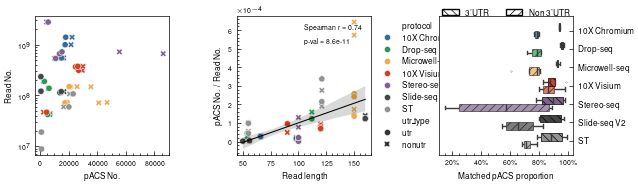

In [3]:
plt.close()
fig, (ax1,ax2, ax3)= plt.subplots(1,3, figsize=(165*mm,50*mm))

sns.scatterplot(
    data=cs_count_by_sample_df[cs_count_by_sample_df["cs_read_num"] == "multi"],
    x="counts",
    y="read_count",
    hue="protocol",
    style="utr_type",
    hue_order=order,
    style_order=["utr","nonutr"],
    palette=palette,
    ax=ax1,
    legend=False,
    s=20
)
# ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel("pACS No.")
ax1.set_ylabel("Read No.")


sns.scatterplot(
    data=cs_count_by_sample_df[cs_count_by_sample_df["cs_read_num"] == "multi"],
    x="read_length",
    y="cs_by_read_counts",
    hue="protocol",
    style="utr_type",
    hue_order=order,
    style_order=["utr","nonutr"],
    palette=palette,
    ax=ax2,
    s=20
)
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# ax2.set_xscale('log')
# ax2.set_yscale('log')
ax2.set_xlabel("Read length")
ax2.set_ylabel("Efficiency")

sns.regplot(
    data = cs_count_by_sample_df[cs_count_by_sample_df["cs_read_num"] == "multi"],
    x="read_length",
    y="cs_by_read_counts",
    scatter=False,
    ax=ax2,
    color="black",
    
)
slope, intercept, r_value, p_value, std_err = stats.linregress(
    cs_count_by_sample_df[cs_count_by_sample_df["cs_read_num"] == "multi"]["read_length"],
    cs_count_by_sample_df[cs_count_by_sample_df["cs_read_num"] == "multi"]["cs_by_read_counts"]
    )
r2 = r_value**2
spearmanr, pval = stats.spearmanr(
    cs_count_by_sample_df[cs_count_by_sample_df["cs_read_num"] == "multi"]["read_length"],
    cs_count_by_sample_df[cs_count_by_sample_df["cs_read_num"] == "multi"]["cs_by_read_counts"]
    )
ax2.annotate(f"Spearman r = {spearmanr:.2f}", (0.5, 0.9), xycoords='axes fraction', fontsize=5)
ax2.annotate(f"p-val = {pval:.1e}",(0.5, 0.8),  xycoords='axes fraction', fontsize=5)
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax2.set_xlabel("Read length")
ax2.set_ylabel("pACS No. / Read No.")
ax2.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')

hatch_styles = ["\\\\\\\\", "////"]
colors = palette
alpha_values = [1, 0.7]

sns.boxplot(
    data=cs_count_df[(cs_count_df["match_type"] == "match") & (cs_count_df["cs_read_num"] == "multi")],
    x="prop",
    y="protocol",
    hue="utr_type",
    hue_order=["utr", "nonutr"],
    order=order,
    ax=ax3,
    legend=False,
    palette=palette,
    flierprops={"markersize":0.2},
    width=0.8,)

for j, bar in enumerate(ax3.patches):
    hatch_index = j // (len(ax3.patches) // len(hatch_styles))
    bar.set_hatch(hatch_styles[hatch_index])
    bar.set_alpha(alpha_values[hatch_index])
    bar.set_facecolor(colors[j % (len(ax3.patches) // len(hatch_styles))])
    bar.set_edgecolor('black')  # 设置描边颜色为黑色
    bar.set_linewidth(0.5)  # 设置描边线宽为1
ax3.spines['top'].set_visible(True)
ax3.spines['right'].set_visible(True)
ax3.xaxis.set_major_formatter(PercentFormatter(xmax=1))
ax3.set_xlabel("Matched pACS proportion")
ax3.set_ylabel("")
# move y-axis to the right
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_yticklabels(ax3.get_yticklabels(), fontsize=6)
ax3.tick_params(which="minor", right=False)
ax3.margins(y=0.06)
handles = [plt.Rectangle((0, 0), 1, 1, facecolor='w', edgecolor='k', hatch=hatch_style) for i, hatch_style in enumerate(hatch_styles)]
labels = ["3'UTR", "Non 3'UTR"]
ax3.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)
# plt.savefig("/root/apabenchmark/plot/fig3/fig3ab.pdf", bbox_inches='tight', dpi=300)

In [5]:
# cs type
cs_motif_unmatch_cat = "/root/apabenchmark/data/raw_bam_feature/cs_motif/motif_category_unmatch.csv"
cs_motif_unmatch_df = pd.read_csv(cs_motif_unmatch_cat)
cs_motif_unmatch_df = cs_motif_unmatch_df.groupby(["protocol", "category","type","match_type","cs_read_num","utr_type"])["count"].sum().reset_index()
cs_motif_unmatch_df["prop"] = cs_motif_unmatch_df.groupby(["protocol","type"])["count"].transform(lambda x: x / x.sum())
cs_motif_unmatch_df["protocol"] = cs_motif_unmatch_df["protocol"].map(protocol_map)
cs_motif_unmatch_df["protocol"] = pd.Categorical(cs_motif_unmatch_df["protocol"], categories=order+["Annotated PAS"])
cs_motif_unmatch_df = cs_motif_unmatch_df.sort_values("protocol")
# cs_motif_unmatch_df["protocol"] = cs_motif_unmatch_df["protocol"].map(protocol_map)

cs_motif_match_cat = "/root/apabenchmark/data/raw_bam_feature/cs_motif/motif_category_match.csv"
cs_motif_match_df = pd.read_csv(cs_motif_match_cat)
cs_motif_match_df = cs_motif_match_df.groupby(["protocol", "category","type","match_type","cs_read_num","utr_type"])["count"].sum().reset_index()
cs_motif_match_df["prop"] = cs_motif_match_df.groupby(["protocol","type"])["count"].transform(lambda x: x / x.sum())
cs_motif_match_df["protocol"] = cs_motif_match_df["protocol"].map(protocol_map)
cs_motif_match_df["protocol"] = pd.Categorical(cs_motif_match_df["protocol"], categories=order+["Annotated PAS"])
cs_motif_match_df = cs_motif_match_df.sort_values("protocol")
cs_motif_df = pd.concat([cs_motif_unmatch_df, cs_motif_match_df])


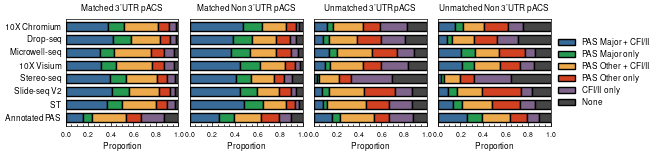

In [6]:
plt.close()
fig = plt.figure(figsize=(170*mm, 42*mm))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1])

bar_width = 0.7
protocol_padding = 0.2
protocols = cs_motif_df['protocol'].unique()
types = ["multi_match_utr", "multi_match_nonutr", "multi_unmatch_utr", "multi_unmatch_nonutr"]
title = ["Matched 3'UTR pACS", "Matched Non 3'UTR pACS", "Unmatched 3'UTR pACS", "Unmatched Non 3'UTR pACS"]
motif_categorys = [
    "PAS Major + CFI/II",
    "PAS Major only",
    "PAS Other + CFI/II",
    "PAS Other only",
    "CFI/II only",
    "None"
]

for i, type_ in enumerate(types):
    ax = plt.subplot(gs[i])
    y = np.arange(len(protocols))
    left = np.zeros(len(protocols))
    for j, motif_category in enumerate(motif_categorys):
        data = cs_motif_df[(cs_motif_df["category"] == motif_category) & (cs_motif_df["type"] == type_)]["prop"].values
        if data.shape[0] == 0:
            continue
        ax.barh(y, data, bar_width, left=left, label=motif_category, color=palette[j], edgecolor='black')
        left += data

    ax.set_xlim([0, 1])
    
    ax.set_ylim([-0.5, len(protocols) - 0.5])
    ax.tick_params(which='both', left=False)
    ax.set_xlabel('Proportion')
    ax.set_ylabel('')
    ax.set_yticks(y)
    ax.set_yticklabels(protocols, fontsize=6)
    ax.set_title(title[i], fontsize=6)
    ax.set_ylim([y[0] - bar_width/2 - protocol_padding, y[-1] + bar_width])
    if i != 0:
        ax.tick_params(labelleft=False)
    ax.invert_yaxis()

motif_handles = [plt.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black', linewidth=1) for color in palette]
motif_labels = motif_categorys
motif_legend = plt.legend(motif_handles, motif_labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=6, )

fig.tight_layout()
fig.subplots_adjust(wspace=0.1, bottom=0.2)
# plt.savefig("/root/apabenchmark/plot/fig3/cs_motif.pdf", dpi=300, bbox_inches="tight")